Theory : https://towardsdatascience.com/understanding-random-forest-58381e0602d2

Examples : https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

# Forests of randomized trees

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

from sklearn.utils import resample

### Set random seed to ensure reproducible runs

In [2]:
RSEED = 50

### Importing data and data cleaning

In [3]:
df_main = pd.read_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced/df_main.csv', index_col=0)
df_main.columns

Index(['rgiid', 'x', 'y', 'Surge', 'Slope', 'Name', 'bed', 'thickness',
       'surface_elevation', 'ELA', 'beta', 'cmb', 'width_centerline'],
      dtype='object')

In [4]:
df_main.drop(df_main[df_main['Surge']==9].index, inplace = True)
df_main.drop(df_main[df_main['Surge']==1].index, inplace = True)
df_main.drop(df_main[df_main['Surge']==2].index, inplace = True)
df = df_main.drop(columns = ['rgiid', 'Name', 'x', 'y', 'ELA', 'beta'])
df.dropna(how='any', inplace=True)

In [5]:
df

,Surge,Slope,bed,thickness,surface_elevation,cmb,width_centerline
0,0,16.7,401.83295,4.167050,406.00000,0.004318,86.307950
1,0,16.7,401.83295,4.167050,406.00000,0.004320,52.001931
2,0,16.7,401.83295,4.167050,406.00000,0.004321,63.412109
3,0,16.7,401.83295,4.167050,406.00000,0.004323,74.822291
4,0,16.7,401.83295,4.167050,406.00000,0.004324,112.223246
...,...,...,...,...,...,...,...
130984,3,11.7,237.64468,50.380424,288.02512,0.004612,278.553621
130985,3,11.7,233.07228,46.717087,279.78937,0.004614,256.755923
130986,3,11.7,233.07228,46.717087,279.78937,0.004618,238.477978
130987,3,11.7,233.18828,47.159560,280.34784,0.004620,226.342325


In [6]:
df_main.groupby('Surge').count()

,rgiid,x,y,Slope,Name,bed,thickness,surface_elevation,ELA,beta,cmb,width_centerline
Surge,,,,,,,,,,,,
0,104245,104245,104245,104245,60242,99044,99044,99044,104079,104079,104079,104097
3,11431,11431,11431,11431,11350,11082,11082,11082,11421,11421,11421,11429


In [5]:
df['Surge'] = df['Surge'].replace({3: 1})
df = df.loc[df['Surge'].isin([0, 1])].copy()
df = df.rename(columns = {'Surge': 'label'})
df['label'].value_counts()

0    98777
1    11073
Name: label, dtype: int64

In [8]:
df['label']

0         0
1         0
2         0
3         0
4         0
         ..
130984    1
130985    1
130986    1
130987    1
130988    1
Name: label, Length: 109850, dtype: int64

In [9]:
df.columns

Index(['label', 'Slope', 'bed', 'thickness', 'surface_elevation', 'cmb',
       'width_centerline'],
      dtype='object')

In [6]:
# Extract the labels
labels = np.array(df.pop('label'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

### Resampling using SMOTE

In [7]:
def resamplingDataPrep(X_train, y_train, target_var): 
    # concatenate our training data back together
    resampling = X_train.copy()
    resampling[target_var] = y_train
    # separate minority and majority classes
    majority_class = resampling[resampling[target_var]==0]
    minority_class = resampling[resampling[target_var]==1]
    # Get a class count to understand the class imbalance.
    print('majority_class: '+ str(len(majority_class)))
    print('minority_class: '+ str(len(minority_class)))
    return majority_class, minority_class

In [8]:
def upsample_SMOTE(X_train, y_train, ratio=1.0):
    """Upsamples minority class using SMOTE.
    Ratio argument is the percentage of the upsampled minority class in relation
    to the majority class. Default is 1.0
    """
    sm = SMOTE(random_state=23, sampling_strategy=ratio)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    print(len(X_train_sm), len(y_train_sm))
    return X_train_sm, y_train_sm

In [9]:
df_majority, df_minority = resamplingDataPrep(train, train_labels, 'labels')
# df_minority = resamplingDataPrep(train, train_labels, 'labels')[1]
df_majority.shape

majority_class: 69144
minority_class: 7751


(69144, 7)

In [10]:
train_SMOTE_x, train_SMOTE_y= upsample_SMOTE(train, train_labels, ratio=1.0)
train_SMOTE_y.shape

138288 138288


(138288,)

In [11]:
# Features for feature importances
features = list(train_SMOTE_x.columns)
features

['Slope', 'bed', 'thickness', 'surface_elevation', 'cmb', 'width_centerline']

### Evaluate the decision tree

In [12]:
def evaluate_model(predictions, probs, train_predictions, train_probs, train_labels):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

### Random forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=1000, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               max_depth = 2,
                               n_jobs=-1, verbose = 1)

# # Fit on training data
# model.fit(train_SMOTE_x, train_SMOTE_y)

In [17]:
#Initializing RFE model
rfe = RFE(model, 3)

/usr/local/lib64/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [18]:
train_rfe_x = rfe.fit_transform(train_SMOTE_x, train_SMOTE_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   19.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   19.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:

In [20]:
train_SMOTE_x.shape

(138288, 6)

In [19]:
model.fit(train_rfe_x,train_SMOTE_y)
print(rfe.support_)
print(rfe.ranking_)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   11.1s


[ True False  True False False  True]
[1 2 1 3 4 1]


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   14.1s finished


### Find the optimal number of features

In [21]:
#no of features
nof_list=np.arange(1,6)            
high_score=0

#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    model = RandomForestClassifier(n_estimators=1000, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               max_depth = 2,
                               n_jobs=-1, verbose = 1)
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(train_SMOTE_x, train_SMOTE_y)
    X_test_rfe = rfe.transform(test)
    model.fit(X_train_rfe, train_SMOTE_y)
    score = model.score(X_test_rfe, test_labels)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

/usr/local/lib64/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   19.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 784 ta

Optimum number of features: 4
Score with 4 features: 0.787286


[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.5s finished


In [22]:
rfe = RFE(model, 4)
X_rfe = rfe.fit_transform(train_SMOTE_x,train_SMOTE_y)

/usr/local/lib64/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=4 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   20.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 784 ta

In [25]:
train_SMOTE_x

,Slope,bed,thickness,surface_elevation,cmb,width_centerline
0,6.100000,389.924380,71.075630,461.000000,0.005463,1498.644806
1,14.200000,184.506270,78.493730,263.000000,0.005159,1073.062761
2,11.200000,104.112600,43.887398,148.000000,0.004758,645.140939
3,14.800000,441.767500,20.048859,461.816350,0.005260,766.536518
4,7.000000,229.919220,125.080780,355.000000,0.003811,1469.176068
...,...,...,...,...,...,...
138283,7.023314,23.829323,195.607451,219.436774,0.006454,2442.671919
138284,14.400000,820.631916,56.567662,877.199582,0.002523,687.791096
138285,9.236777,-6.903990,363.834078,356.930087,0.005926,6175.787679
138286,4.658367,-23.234087,207.079499,183.845413,0.003552,5233.173310


In [26]:
#Fitting the data to model
model.fit(X_rfe,train_SMOTE_y)              
temp = pd.Series(rfe.support_,index = train_SMOTE_x.columns)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   16.8s


Index(['Slope', 'bed', 'thickness', 'width_centerline'], dtype='object')


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   21.2s finished


In [62]:
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 7
Average maximum depth 2


In [63]:
train_rf_predictions = model.predict(train_SMOTE_x)
train_rf_probs = model.predict_proba(train_SMOTE_x)[:, 1]

rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Paral

In [71]:
pd.DataFrame({'true':test_labels, 'predictions':rf_predictions, 'probs':rf_probs}).to_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced/df_compare_roc_RF_SMOTE.csv')

In [67]:
train_rf_probs.shape

(138288,)

Recall Baseline: 1.0 Test: 0.75 Train: 0.74
Precision Baseline: 0.1 Test: 0.27 Train: 0.77
Roc Baseline: 0.5 Test: 0.84 Train: 0.84


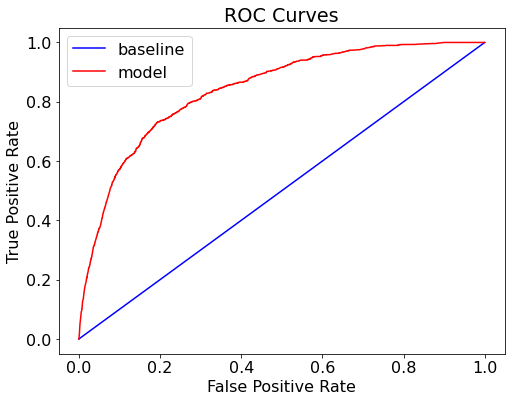

In [70]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs, train_SMOTE_y)

In [72]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[23086  6547]
 [  842  2480]]


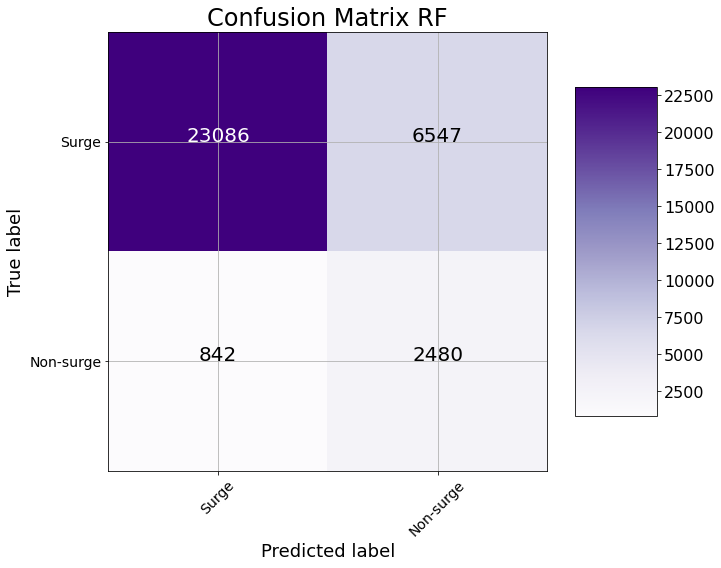

In [73]:
cm_rf = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm_rf, classes = ['Surge', 'Non-surge'],
                      title = 'Confusion Matrix RF', cmap='Purples')

In [74]:
from sklearn.metrics import average_precision_score
average_precision_rf = average_precision_score(test_labels, rf_predictions)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_rf))

Average precision-recall score: 0.23


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.7s finished


Text(0.5, 1.0, '2-class Precision-Recall curve RF: AP=0.23')

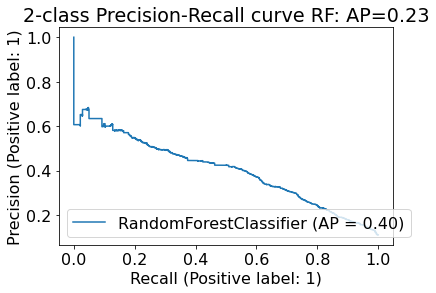

In [75]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp_rf = plot_precision_recall_curve(model, test, test_labels)
disp_rf.ax_.set_title('2-class Precision-Recall curve RF: '
                   'AP={0:0.2f}'.format(average_precision_rf))

In [31]:
fi = pd.DataFrame({'feature': features,
                   'importance': tree.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head()

,feature,importance
0,Slope,0.313662
4,cmb,0.203893
5,width_centerline,0.194063
2,thickness,0.115517
1,bed,0.087398


# Gradient boosting

In [28]:
import xgboost
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

In [29]:
dmatrix_train = xgboost.DMatrix(train_SMOTE_x, label=train_SMOTE_y)
dmatrix_test = xgboost.DMatrix(test, label=test_labels)

In [30]:
params = {'objective':'reg:logistic', 'num_boost_round':20000, 'max_depth':1, 'scale_pos_weight':0.3}

xgb = xgboost.train(params, dmatrix_train, num_boost_round=20000)

[20:28:13] WARNING: ../src/learner.cc:541: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [31]:
predictions_xgboost = xgb.predict(dmatrix_test)
pd.DataFrame({'true':test_labels, 'predictions':predictions_xgboost})
pd.DataFrame({'true':test_labels, 'predictions':predictions_xgboost}).to_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced/df_compare_roc_xgboost_SMOTE.csv')

Text(0.6, 0.0, 'AUC = 0.92')

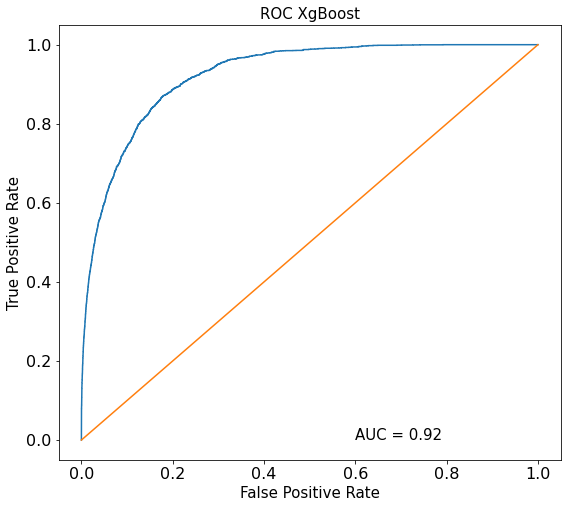

In [81]:
fpr, tpr, t = metrics.roc_curve(y_true=test_labels, y_score=predictions_xgboost)

fig, ax = plt.subplots(figsize=(9, 8))

ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1])

ax.set_ylabel('True Positive Rate', fontsize=15)
ax.set_xlabel('False Positive Rate', fontsize=15)
ax.set_title('ROC XgBoost', fontsize=15)
ax.text(
s = 'AUC = ' + str(round(metrics.roc_auc_score(y_true=test_labels, y_score=predictions_xgboost),2))
    , x=0.6, y=0.0, fontsize=15
)

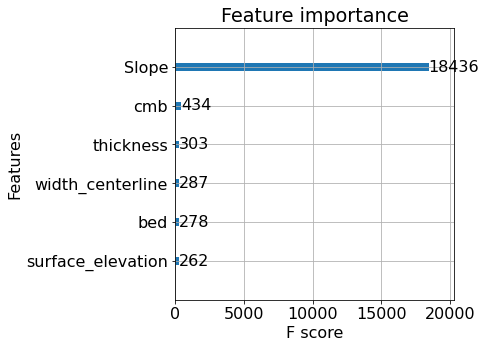

In [82]:
fig, ax = plt.subplots(figsize=(5, 5))
xgboost.plot_importance(xgb, ax=ax)

In [83]:
average_precision_xgboost = average_precision_score(test_labels, predictions_xgboost)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_xgboost))

Average precision-recall score: 0.64


In [39]:
test_labels.dtype

dtype('int64')

Confusion matrix, without normalization
[[28434  1199]
 [ 1460  1862]]


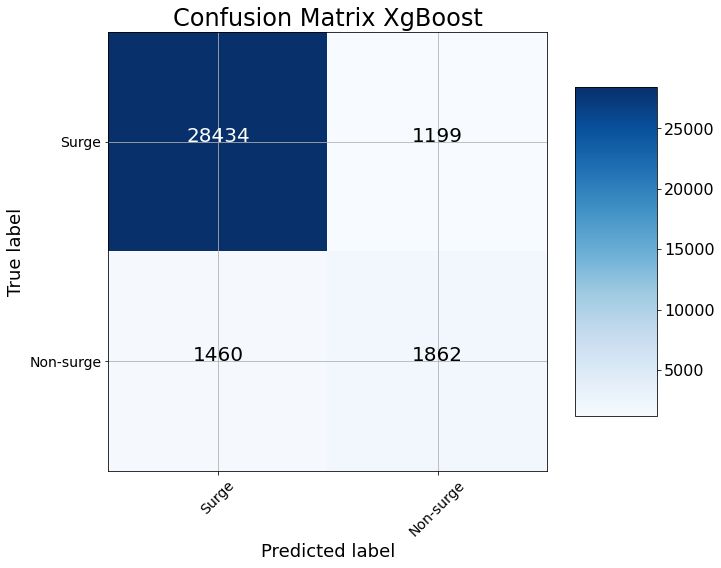

In [84]:
# confusion_matrix(test_labels, predictions.round())
cm_xgboost = confusion_matrix(test_labels, predictions_xgboost.round())
plot_confusion_matrix(cm_xgboost, classes = ['Surge', 'Non-surge'],
                      title = 'Confusion Matrix XgBoost', cmap='Blues')

Theory: https://towardsdatascience.com/introduction-to-logistic-regression-66248243c148

Example: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

# Logistic regression

In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
logreg = LogisticRegression()
logreg.fit(train_SMOTE_x, train_SMOTE_y)

LogisticRegression()

In [37]:
train_SMOTE_x.shape

(138288, 6)

In [35]:
predictions_LR = logreg.predict(test)
probs_LR = logreg.predict_proba(test)[:, 1]
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(test, test_labels)))

Accuracy of logistic regression classifier on test set: 0.74


In [38]:
#no of features
nof_list=np.arange(1,6)            
high_score=0

#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    model = logreg
    rfe = RFE(model,nof_list[n])
    X_train_rfe_logreg = rfe.fit_transform(train_SMOTE_x, train_SMOTE_y)
    X_test_rfe_logreg = rfe.transform(test)
    model.fit(X_train_rfe_logreg, train_SMOTE_y)
    score = model.score(X_test_rfe_logreg, test_labels)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

/usr/local/lib64/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/usr/local/lib64/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/usr/local/lib64/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/usr/local/lib64/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_se

Optimum number of features: 3
Score with 3 features: 0.734577


In [39]:
rfe = RFE(model, 3)
X_rfe_LR = rfe.fit_transform(train_SMOTE_x,train_SMOTE_y)

/usr/local/lib64/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [40]:
#Fitting the data to model
model.fit(X_rfe_LR,train_SMOTE_y)              
temp = pd.Series(rfe.support_,index = train_SMOTE_x.columns)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['Slope', 'thickness', 'cmb'], dtype='object')


In [44]:
test_labels.sum()

3322

In [88]:
pd.DataFrame({'true':test_labels, 'predictions':predictions_LR, 'prob':probs_LR}).to_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced/df_compare_roc_LR_SMOTE.csv')

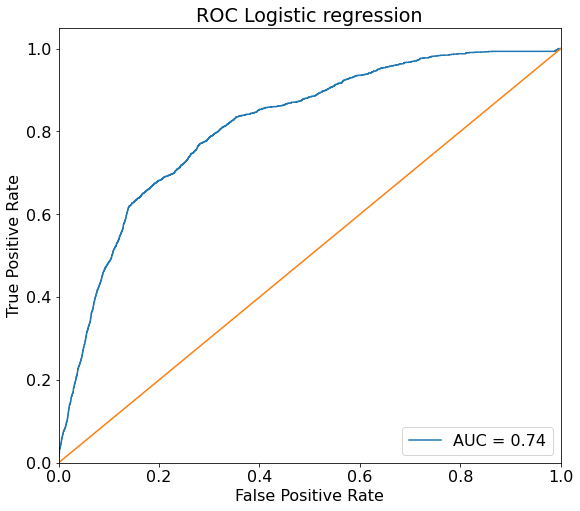

In [89]:
logit_roc_auc = roc_auc_score(test_labels, logreg.predict(test))
fpr, tpr, thresholds = roc_curve(test_labels, logreg.predict_proba(test)[:,1])
plt.figure(figsize=(9, 8))
plt.plot(fpr, tpr, label='AUC = %0.2f' % logit_roc_auc)
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Logistic regression')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

<function confusion_matrix at 0x7f766db45a60>
Confusion matrix, without normalization
[[21800  7833]
 [  844  2478]]


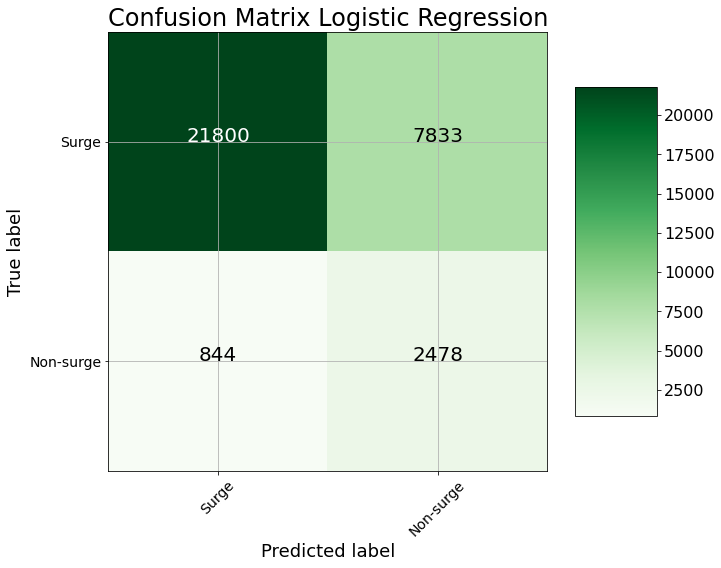

In [90]:
from sklearn.metrics import confusion_matrix
cm_LR = confusion_matrix(test_labels, predictions_LR)
print(confusion_matrix)
plot_confusion_matrix(cm_LR, classes = ['Surge', 'Non-surge'],
                      title = 'Confusion Matrix Logistic Regression', cmap='Greens')

In [91]:
average_precision_LR = average_precision_score(test_labels, predictions_LR)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_LR))

Average precision-recall score: 0.20


Text(0.5, 1.0, '2-class Precision-Recall curve RF: AP=0.20')

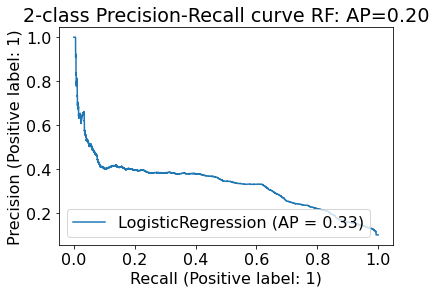

In [92]:
disp_lr = plot_precision_recall_curve(logreg, test, test_labels)
disp_lr.ax_.set_title('2-class Precision-Recall curve RF: '
                   'AP={0:0.2f}'.format(average_precision_LR))